In [19]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import calendar
import random
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold
from imblearn.over_sampling import SMOTE
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [8]:
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
labeled_path = os.path.join(parent_dir, "data", "data_final","labeled_data.csv")
labeled_data = pd.read_csv(labeled_path)

In [9]:
def preprocess_user_data(df, is_train=True, scaler=None, label_encoders=None):
    df = df.copy()

    for col in ['msno', 'registration_init_time']:
        if col in df.columns:
            df.drop(columns=col, inplace=True)

    for col in ['last_login_date_previous', 'last_login_date_current']:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors='coerce')

    if all(c in df.columns for c in ['last_login_date_current', 'last_login_date_previous']):
        default_date = pd.to_datetime("1970-01-01")
        df['days_until_month_end'] = ((df['last_login_date_current'] + pd.offsets.MonthEnd(0)) - df['last_login_date_current']).dt.days
        df['last_login_interval'] = (df['last_login_date_current'] - df['last_login_date_previous']).dt.days

        curr_is_default = df['last_login_date_current'] == default_date
        prev_is_default = df['last_login_date_previous'] == default_date
        both_default = curr_is_default & prev_is_default

        df.loc[curr_is_default & ~both_default, 'days_until_month_end'] = 45
        df.loc[curr_is_default & ~both_default, 'last_login_interval'] = df.loc[curr_is_default & ~both_default].apply(
            lambda row: 45 + (calendar.monthrange(row['last_login_date_previous'].year, row['last_login_date_previous'].month)[1] - row['last_login_date_previous'].day)
            if row['last_login_date_previous'] != default_date else 90,
            axis=1
        )
        df.loc[prev_is_default & ~both_default, 'days_until_month_end'] = 45
        df.loc[prev_is_default & ~both_default, 'last_login_interval'] = df.loc[prev_is_default & ~both_default].apply(
            lambda row: 45 + calendar.monthrange(row['last_login_date_current'].year, row['last_login_date_current'].month)[1]
            if row['last_login_date_current'] != default_date else 90,
            axis=1
        )
        df.loc[both_default, 'days_until_month_end'] = 90
        df.loc[both_default, 'last_login_interval'] = 90

        for col in ['last_login_date_previous', 'last_login_date_current']:
            if col in df.columns:
                df.drop(columns=col, inplace=True)

    cat_cols = ['gender', 'city', 'registered_via']
    fitted_label_encoders = {}
    for col in cat_cols:
        if col in df.columns:
            df[col] = df[col].astype(str)
            if is_train:
                le = LabelEncoder()
                df[col] = le.fit_transform(df[col])
                fitted_label_encoders[col] = le
            else:
                le = label_encoders[col]
                df[col] = le.transform(df[col])

    if is_train:
        y = torch.tensor(df['is_churn'].astype(int).values, dtype=torch.float32)
        df.drop(columns=['is_churn'], inplace=True)
    else:
        y = None
        df.drop(columns=['is_churn'], inplace=True)

    if is_train:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(df)
    else:
        X_scaled = scaler.transform(df)

    X_scaled = torch.tensor(X_scaled, dtype=torch.float32)  # ✅ 转为Tensor

    return (X_scaled, y, scaler, fitted_label_encoders) if is_train else X_scaled


In [10]:
X_labled, y, scaler, fitted_label_encoders = preprocess_user_data(labeled_data, is_train=True, scaler=None, label_encoders=None)

In [ ]:
# Example Split
X_train, X_test, y_train, y_test = train_test_split(
    X_labled, y, test_size=0.2, random_state=42, stratify=y
)

In [12]:
def resample_smote_then_downsample(X, y, downsample_ratio=1.0):
    sm = SMOTE(random_state=42)
    X_res, y_res = sm.fit_resample(X.cpu().numpy(), y.cpu().numpy())

    df = pd.DataFrame(X_res)
    df['label'] = y_res
    majority = df[df['label'] == 0]
    minority = df[df['label'] == 1]
    majority_down = majority.sample(n=int(len(minority) * downsample_ratio), random_state=42)
    df_resampled = pd.concat([majority_down, minority], axis=0).sample(frac=1, random_state=42)

    X_final = torch.tensor(df_resampled.drop(columns='label').values, dtype=torch.float32)
    y_final = torch.tensor(df_resampled['label'].values, dtype=torch.float32)
    return X_final, y_final

X_train_resampled, y_train_resampled = resample_smote_then_downsample(X_train, y_train)


In [ ]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dims, dropout_rate=0.3):
        super(MLPClassifier, self).__init__()
        layers = []
        last_dim = input_dim
        for h_dim in hidden_dims:
            layers.append(nn.Linear(last_dim, h_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            last_dim = h_dim
        layers.append(nn.Linear(last_dim, 1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x).squeeze()

    def reset_weights(self):
        for layer in self.model:
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()


In [ ]:
def train_model(model, train_loader, val_loader, threshold=0.5, epochs=30, lr=0.001, patience=5,
                device=torch.device("cpu"), return_logs=False, log_path=None):

    model = model
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss() 
    best_val_loss = float('inf')
    best_model_state = None
    no_improve_epochs = 0
    logs = {'train_loss': [], 'val_loss': [], 'val_f1': []}

    for epoch in tqdm(range(epochs), desc="Training Epochs"):
        model.train()
        train_losses = []
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device, non_blocking=True)
            y_batch = y_batch.to(device, non_blocking=True)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        model.eval()
        val_losses, y_true, y_pred = [], [], []
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val = X_val.to(device, non_blocking=True)
                y_val = y_val.to(device, non_blocking=True)
                outputs = model(X_val)
                loss = criterion(outputs, y_val)
                val_losses.append(loss.item())
                preds = (torch.sigmoid(outputs) >= threshold).int()
                y_pred.append(preds.cpu())
                y_true.append(y_val.cpu())

        y_true = torch.cat(y_true).numpy()
        y_pred = torch.cat(y_pred).numpy()
        val_loss = np.mean(val_losses)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        logs['train_loss'].append(np.mean(train_losses))
        logs['val_loss'].append(val_loss)
        logs['val_f1'].append(f1)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            no_improve_epochs = 0
        else:
            no_improve_epochs += 1
            if no_improve_epochs >= patience:
                break

    model.load_state_dict(best_model_state)
    if log_path:
        pd.DataFrame(logs).to_csv(log_path, index=False)
    return (model, logs) if return_logs else model


In [33]:
def run_random_search(X, y, param_grid, k=3, epochs=30, batch_size=256, patience=5, device='cpu'):
    best_params, best_avg_f1, best_model = None, -1, None
    results = []
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

    for params in param_grid:
        hidden_dims = params['hidden_dims']
        lr = params['lr']
        dropout = params['dropout']
        threshold = 0.5
        fold_f1_scores = []
        best_f1_for_params = -1
        print(f"\nTesting params: hidden_dims={hidden_dims}, lr={lr}, dropout={dropout}, threshold={threshold}")

        model = MLPClassifier(input_dim=X.shape[1], hidden_dims=hidden_dims, dropout_rate=dropout)

        fold_accuracies, fold_precisions, fold_recalls = [], [], []

        for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
            model.reset_weights()
            X_tr, X_val = X[train_idx], X[val_idx]
            y_tr, y_val = y[train_idx], y[val_idx]

            train_loader = DataLoader(TensorDataset(X_tr, y_tr), batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size, shuffle=False)

            model, logs = train_model(model, train_loader, val_loader, threshold=threshold,
                                   epochs=epochs, lr=lr, patience=patience, device=device, return_logs=True)

            plt.figure(figsize=(8, 5))
            plt.plot(logs['train_loss'], label='Train Loss')
            plt.plot(logs['val_loss'], label='Val Loss')
            plt.plot(logs['val_f1'], label='Val F1')
            plt.xlabel('Epoch')
            plt.ylabel('Loss / F1')
            plt.title(f'Fold {fold} Training Curve')
            plt.legend()
            plt.tight_layout()
            plt.show()


            model.eval()
            y_preds = []
            with torch.no_grad():
                for X_batch, _ in val_loader:
                    X_batch = X_batch.to(device, non_blocking=True)
                    preds = (torch.sigmoid(model(X_batch)) >= threshold).int()
                    y_preds.append(preds.cpu())

            y_val_np = y_val.cpu().numpy()
            y_pred_np = torch.cat(y_preds).numpy()
            f1 = f1_score(y_val_np, y_pred_np)
            accuracy = accuracy_score(y_val_np, y_pred_np)
            precision = precision_score(y_val_np, y_pred_np, zero_division=0)
            recall = recall_score(y_val_np, y_pred_np, zero_division=0)

            print(f"Fold {fold} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

            fold_f1_scores.append(f1)
            fold_accuracies.append(accuracy)
            fold_precisions.append(precision)
            fold_recalls.append(recall)

            best_f1_for_params = max(best_f1_for_params, f1)

        avg_f1 = np.mean(fold_f1_scores)
        avg_accuracy = np.mean(fold_accuracies)
        avg_precision = np.mean(fold_precisions)
        avg_recall = np.mean(fold_recalls)

        results.append((params, avg_f1))

        print(f"🔹 Avg Accuracy: {avg_accuracy:.4f}, Precision: {avg_precision:.4f}, Recall: {avg_recall:.4f}, F1: {avg_f1:.4f}")

        if avg_f1 > best_avg_f1:
            best_avg_f1 = avg_f1
            best_params = params
            best_model = MLPClassifier(input_dim=X.shape[1], hidden_dims=hidden_dims, dropout_rate=dropout)
            best_model.load_state_dict(model.state_dict())

    return best_params, results


In [34]:
# Generate Random Param Grid
def generate_random_param_grid(n_samples=6):
    hidden_dims_choices = [[128, 64], [512, 256], [256, 128, 64]]
    lr_choices = [0.0001, 0.0005, 0.001]
    dropout_choices=[0.1,0.2,0.3]
    grid = []
    for _ in range(n_samples):
        grid.append({
            'hidden_dims': random.choice(hidden_dims_choices),
            'lr': random.choice(lr_choices),
            'dropout': random.choice(dropout_choices),
        })
    print("Generated Parameter Grid:")
    for i, params in enumerate(grid, 1):
        print(f"{i}. hidden_dims: {params['hidden_dims']}, lr: {params['lr']}, dropout: {params['dropout']}")
    
    return grid

# Run Random Search
param_grid = generate_random_param_grid(12)



Generated Parameter Grid:
1. hidden_dims: [512, 256], lr: 0.001, dropout: 0.2
2. hidden_dims: [256, 128, 64], lr: 0.001, dropout: 0.1
3. hidden_dims: [128, 64], lr: 0.0005, dropout: 0.3
4. hidden_dims: [256, 128, 64], lr: 0.0001, dropout: 0.2
5. hidden_dims: [512, 256], lr: 0.0005, dropout: 0.2
6. hidden_dims: [512, 256], lr: 0.0005, dropout: 0.2
7. hidden_dims: [128, 64], lr: 0.001, dropout: 0.2
8. hidden_dims: [256, 128, 64], lr: 0.001, dropout: 0.1
9. hidden_dims: [512, 256], lr: 0.0005, dropout: 0.2
10. hidden_dims: [512, 256], lr: 0.0005, dropout: 0.2
11. hidden_dims: [128, 64], lr: 0.0001, dropout: 0.3
12. hidden_dims: [512, 256], lr: 0.0001, dropout: 0.1



Testing params: hidden_dims=[512, 256], lr=0.001, dropout=0.2, threshold=0.5


Training Epochs: 100%|██████████| 30/30 [09:27<00:00, 18.91s/it]


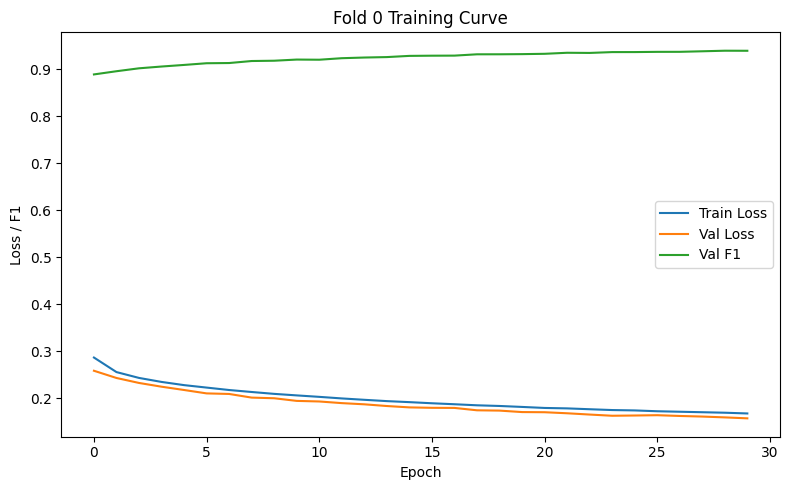

Fold 0 - Accuracy: 0.9383, Precision: 0.9186, Recall: 0.9617, F1: 0.9397


Training Epochs: 100%|██████████| 30/30 [09:27<00:00, 18.92s/it]


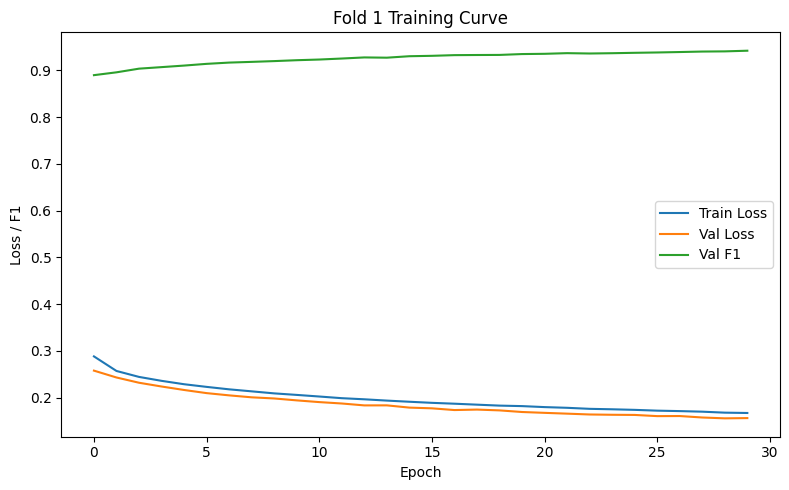

Fold 1 - Accuracy: 0.9406, Precision: 0.9216, Recall: 0.9631, F1: 0.9419


Training Epochs: 100%|██████████| 30/30 [09:31<00:00, 19.05s/it]


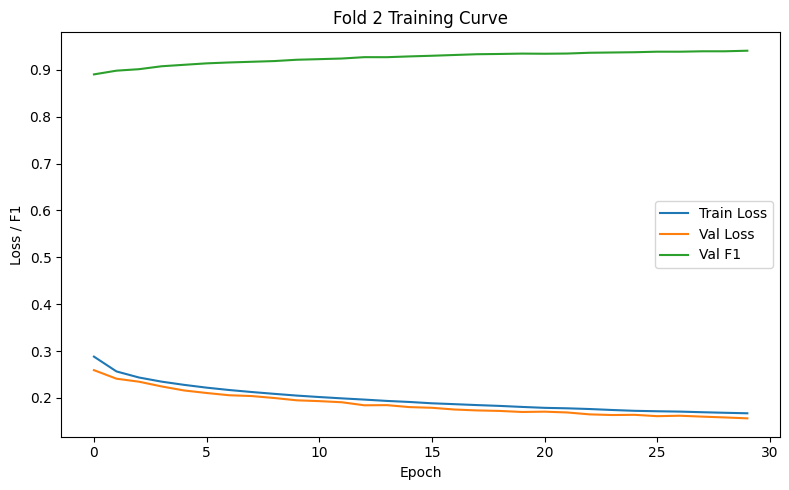

Fold 2 - Accuracy: 0.9391, Precision: 0.9173, Recall: 0.9652, F1: 0.9407


Training Epochs: 100%|██████████| 30/30 [09:58<00:00, 19.94s/it]


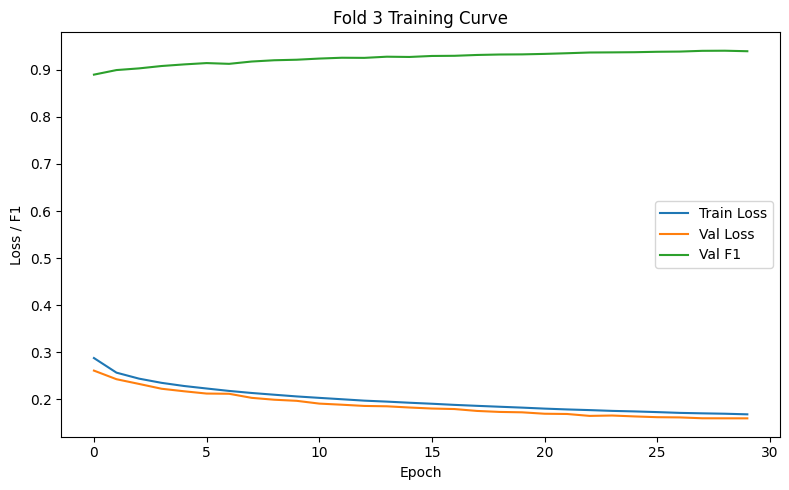

Fold 3 - Accuracy: 0.9376, Precision: 0.9109, Recall: 0.9700, F1: 0.9395


Training Epochs:  80%|████████  | 24/30 [09:56<02:29, 24.87s/it]


KeyboardInterrupt: 

In [ ]:
best_params, results = run_random_search(
    X_train_resampled, y_train_resampled,
    param_grid=param_grid,
    k=3,
    epochs=30,
    batch_size=256,
    patience=5,
    device='cpu'
)

In [ ]:

param_result_df = pd.DataFrame([
    {**params, 'avg_f1': avg_f1} for params, avg_f1 in results
])
param_result_df.to_csv("random_search_results.csv", index=False)

# Final training on full training set using best_params
batch_size = 256
epochs = 20
patience = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

final_loader = DataLoader(
    TensorDataset(X_train_resampled, y_train_resampled),
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True
)

final_model = MLPClassifier(
    input_dim=X_train_resampled.shape[1],
    hidden_dims=best_params['hidden_dims'],
    dropout_rate=best_params['dropout']
)

final_model, final_logs = train_model(
    final_model,
    final_loader,
    final_loader,
    threshold=best_params['threshold'],
    epochs=epochs,
    lr=best_params['lr'],
    patience=patience,
    device=device,
    return_logs=True,
    log_path="best_logs.csv"
)

torch.save(final_model.state_dict(), "best_mlp_model.pt")
print(f"\nBest Params: {best_params}")